# Exercise 3 -- Improving the recurrent model

In this exercise we will try different ways to improve the performance of the RNN model on the PTB data set.

## Gradient clipping

As a first step, we consider the effect of gradient clipping. Gradient clipping reduces the maximum magnitude of the gradient during parameter update to a selectable value $M$. In other words during gradient descent, new parameters $\theta_k$ are determined by applying
$$
\theta_k = \theta_{k-1} - \gamma \nabla J(\theta_{k-1})
$$
where $\nabla J(\theta_{k-1})$ is the gradient and $\gamma$ the learning rate. Gradient clipping then corresponds to introduction of a function
$$
clip_M(\theta) = 
\begin{cases}
\theta & \mathrm{if} ||\theta|| \leq M \\
M \frac{\theta}{||\theta||} \qquad & \mathrm{if} ||\theta|| \leq M
\end{cases}
$$
which is applied during parameter update as follows:
$$
\theta_k = \theta_{k-1} - \gamma clip_M(\theta)(\nabla J(\theta_{k-1})).
$$
We set our model and training loops up as in exercise 2, but use the gradient clipping routine `clip_grad_norm_()` provided by pytorch in the `train()` function and also increase the learning rate as that should be safely possible with gradient clipping. 

In [1]:
import torch
from mymodel import MyNetwork
torch.manual_seed(3932324365)
device = torch.device("cuda")
model = MyNetwork().to(device)

In [2]:
from corpus import Corpus
corpus = Corpus('ptb_data')

batch_size = 100
l_seq = 20

from fcns import batchify, get_batch
train_data = batchify(corpus.train, batch_size).to(device)
val_data = batchify(corpus.valid, batch_size).to(device)
test_data = batchify(corpus.test, batch_size).to(device)

In [3]:
import torch.optim as optim
lr = 5
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)

In [4]:
import time
import math

def train():
    model.train()
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i, l_seq)
        
        optimizer.zero_grad()
        
        output, hidden = model(data)
        loss = loss_fn(output, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
    model.epoch += 1

In [5]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, l_seq):
            data, targets = get_batch(data_source, i, l_seq)
            output, hidden = model(data, hidden)
            total_loss += len(data) * loss_fn(output, targets).item()
    return total_loss / (len(data_source) - 1)

In [6]:
def train_nepochs(nepochs, fname, fname_best):
    
    for epoch in range(1, nepochs+1):
        
        epoch_start_time = time.time()
        train()
        
        model.train_loss.append(evaluate(train_data))
        model.val_loss.append(evaluate(val_data))
        
        time_epoch = time.time() - epoch_start_time
        model.time += time_epoch
        
        print('|          {:3d} |   {:9.1f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
              .format(model.epoch, time_epoch, model.train_loss[-1], model.val_loss[-1], 
                  math.exp(model.train_loss[-1]), math.exp(model.val_loss[-1])))
        print('-' * 78)
        
        # Save the model if the validation loss is the best we've seen so far.
        if len(model.val_loss) == 1 or model.val_loss[-1] < min(model.val_loss[:-1]):
            with open(fname_best, 'wb') as f:
                torch.save(model, f)
        
        with open(fname, 'wb') as f:
            torch.save(model, f)

With everything in place, we can proceed with the training of our model:

In [7]:
# Loop over epochs.
best_val_loss = None
nepochs = 50
log_interval = 1000
clip = .25
fname = 'exercise3_gc.torch'
fname_best = 'exercise3_gc_best.torch'

from fcns import print_log_head, load_model
from os.path import exists

if not exists(fname):
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1326.4s |    4.57 |    5.34 |       96.87 |      209.00 |
------------------------------------------------------------------------------


We plot now the training and validation loss of the model in the figure below. Compared to the loss obtained in exercise 2, we find that the loss is a lot smoother as a function of epoch due to the effect of the gradient clipping. This indicates also, that the spikeyness observed in connection with exercise 2 is related to the *exploding gradient* problem in RNNs. Furthermore we observe a tendency to overfit to the training data from about epoch 5 onwards. Despite this the validation loss continues to improve until about epoch 30.

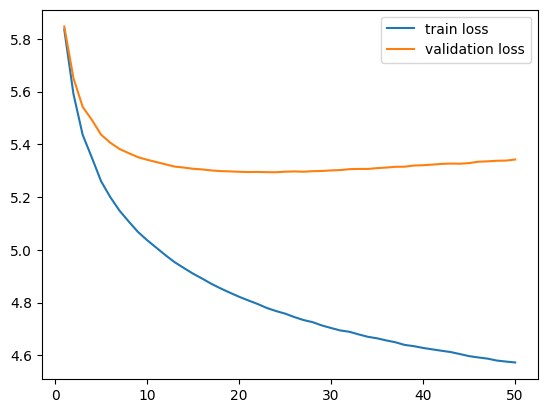

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

As a last performance metric for the evaluation of gradient clipping, we compute the perplexity of the best obtained model on the test data.

In [9]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   24
The perpelexity in the validation set is   199.17
The perpelexity in the test set is         188.60


The best loss was obtained after 24 epochs of training, showing that the higher learning rate enabled by gradient clipping allowed us to train our model faster and more efficiently. In comparison with the performance observed in exercise 2, we get here slightly worse performance, which is likely connected to the 5 times larger learning rate and a smaller learning rate would probably allow for better performance of the model. We will explore the effect of a learning rate scheduler further below.

## Improving the flow of information

In order to improve the flow of information, we pass the hidden state on to the next training iteration. This is simply achieved by adding the hidden state to the inputs of the `model()` call. However we also need to prevent the model from backpropagating through the training iterations. We achieve this by wrapping the hidden state tensor into a new tensor, which is detached from its "history" in each iteration of the training loop. The following code snippets show the approach.

We first define a function to detach the hidden state from backpropagation.

In [10]:
from fcns import repackage_hidden
from IPython.display import Code
Code(data=''.join([line for line in open('fcns.py')][34:42]), language='python')

def repackage_hidden(h):
    """ Credit for this function:
        https://github.com/pytorch/examples/blob/main/word_language_model/main.py
    """
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

Next we update the `forward()` function of our model to include the hidden state passing.

In [11]:
Code(data=''.join([line for line in open('mymodel.py')][35:45]), language='python')

def forward(self, input, hidden=None):
        # Apply word embedding to input
        embedded = self.embedding(input)

        # Forward pass through the RNN layer
        if hidden is not None:
            output, hidden = self.rnn(embedded, hidden)
        else:
            output, hidden = self.rnn(embedded)

We the need to modify the call to `model()` and use our new function `repackage_hidden()` to detach the hidden stat in each iteration.

In [12]:
import time
import math

def train():
    model.train()
    hidden = model.init_hidden(batch_size)
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i, l_seq)
        
        optimizer.zero_grad()
        hidden = repackage_hidden(hidden)
        output, hidden = model(data, hidden)
        loss = loss_fn(output, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
    model.epoch += 1

Similarly we modify the `evaluate()`function to also pass the hidden state to the model and detach the hidden state:

In [13]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, l_seq):
            data, targets = get_batch(data_source, i, l_seq)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(data) * loss_fn(output, targets).item()
    return total_loss / (len(data_source) - 1)

With all code modifications in place, we can now train our model with improved information flow.

In [14]:
# Loop over epochs.
best_val_loss = None
fname = 'exercise3_iif.torch'
fname_best = 'exercise3_iif_best.torch'

from fcns import print_log_head, load_model
from os.path import exists

if not exists(fname):
    model = MyNetwork().to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1322.0s |    4.55 |    5.31 |       94.87 |      202.31 |
------------------------------------------------------------------------------


We plot the train and validation loss as a function of epoch below. Overall the loss looks very similar to the previous part, where we introduced gradient clipping. 

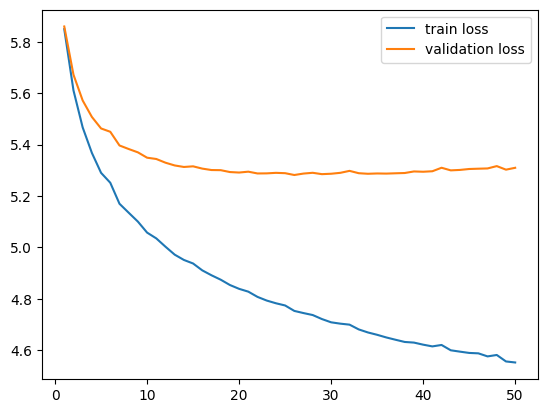

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

The best loss was obtained after 26 epochs of training and we achieved slightly better performance without modifying the learning rate compared to the previous section, but still not as good as we observed in exercise 2. This shows that improving the information flow by passing the hidden state does not just straight-up improve the RNN by enabling to learn longer term dependencies, but the RNN must also be able to learn these long-term dependencies, which is sensitively dependent on other design- and hyper-parameters.

In [16]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   26
The perpelexity in the validation set is   196.72
The perpelexity in the test set is         187.00


## Gated units

We now replace the Elman RNN by the LSTM. This is easily done using pytorch's `LSTM()` layer. We have followed the ideas outlined in https://github.com/pytorch/examples/blob/main/word_language_model/main.py and included an argument `rnn_type` in the definition of the `MyNetwork()` class, which allows to switch over from the Elman RNN to the LSTM unit.

In [17]:
model = MyNetwork(rnn_type='LSTM').to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)

In [18]:
fname = 'exercise3_lstm.torch'
fname_best = 'exercise3_lstm_best.torch'

if not exists(fname):
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1498.2s |    4.31 |    5.14 |       74.41 |      171.24 |
------------------------------------------------------------------------------


We observe that the loss in the LSTM is a lot smoother as a function of epoch than what we have obtained thus far for the Elman RNN, suggesting that the LSTM is a bit easier to train. We observe quite some overfitting to the training data from about epoch 27 onwards.

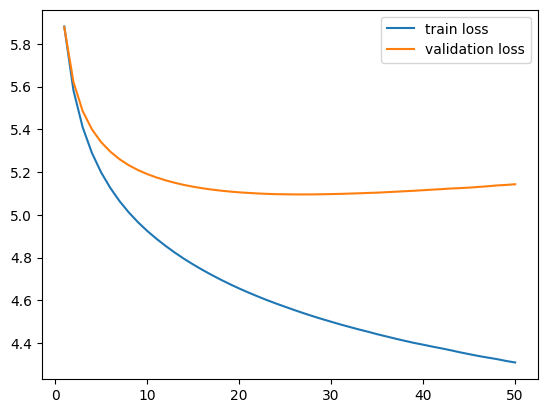

In [19]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

The best model was obtained after 27 epochs of training. It performs much better than the Elman RNN judging from the perplexity scores. We continue to see the trend, that the perplexity on the validation data is worse than it is on the test data.

In [20]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   27
The perpelexity in the validation set is   163.27
The perpelexity in the test set is         154.51


## Improving the model further

As a last part of this assignment we consider further improvements to the model.

### Increasing the number of layers

First we will increase the number of layers to increase the expressiveness of the model.

In [21]:
fname = 'exercise3_lnl.torch'
fname_best = 'exercise3_lnl_best.torch'

if not exists(fname):
    model = MyNetwork(rnn_type='LSTM', nlayers=2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|           50 |      1708.6s |    4.25 |    5.12 |       69.98 |      166.55 |
------------------------------------------------------------------------------


The loss as a function of epoch continues to look similar to the other loss curves we have observed thus far. There is a strong overfitting to the training data present after about epoch 20.

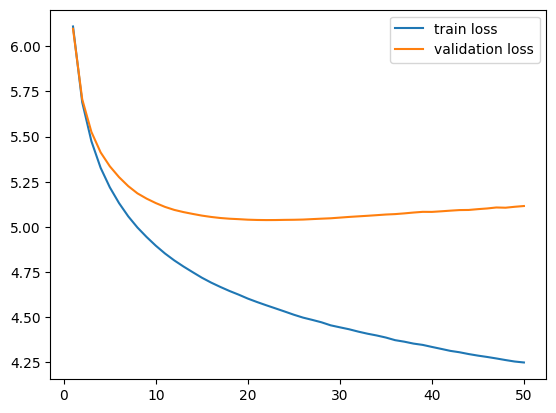

In [22]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

The best model was now obtained after 22 epochs of training and it performed a bit better than the model considering only one layer., suggesting that the model is able to learn more of the patterns inherent to the data set.

In [23]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   22
The perpelexity in the validation set is   154.07
The perpelexity in the test set is         147.82


### Use a learning rate scheduler

As a second improvement we consider the effect of introducing a learning rate scheduler. To that end we modify the code in the `train_nepochs()` function to include the scheduler code. We use here the pytorch `torch.optim.lr_scheduler.ReduceLROnPlateau` scheduler, which reduces the learning rate after a selectable period of no improvements in the loss.

In [24]:
def train_nepochs(nepochs, fname, fname_best):
    
    for epoch in range(1, nepochs+1):
        
        epoch_start_time = time.time()
        train()
        
        model.train_loss.append(evaluate(train_data))
        model.val_loss.append(evaluate(val_data))

        scheduler.step(model.val_loss[-1])
        
        time_epoch = time.time() - epoch_start_time
        model.time += time_epoch
        
        print('|          {:3d} |   {:9.1f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
              .format(model.epoch, time_epoch, model.train_loss[-1], model.val_loss[-1], 
                  math.exp(model.train_loss[-1]), math.exp(model.val_loss[-1])))
        print('-' * 78)
        
        # Save the model if the validation loss is the best we've seen so far.
        if len(model.val_loss) == 1 or model.val_loss[-1] < min(model.val_loss[:-1]):
            with open(fname_best, 'wb') as f:
                torch.save(model, f)
        
        with open(fname, 'wb') as f:
            torch.save(model, f)

We train the network starting with the same parameters as before. The learning rate scheduler should reduce the learning rate step by step as we approch the minimum of the loss.

In [25]:
fname = 'exercise3_lrsched.torch'
fname_best = 'exercise3_lrsched_best.torch'

if not exists(fname):
    model = MyNetwork(rnn_type='LSTM', nlayers=2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    print_log_head()
    train_nepochs(nepochs, fname, fname_best)
else:
    model = load_model(fname)

------------------------------------------------------------------------------
|              |             |       loss        |        perplexity         |
| end of epoch |     time    |-------------------|---------------------------|
|              |             |  train  |  valid  |    train    |    valid    |
------------------------------------------------------------------------------
------------------------------------------------------------------------------
|            1 |        34.6s |    6.08 |    6.07 |      435.58 |      430.86 |
------------------------------------------------------------------------------
|            2 |        35.3s |    5.69 |    5.71 |      294.42 |      300.64 |
------------------------------------------------------------------------------
|            3 |        35.6s |    5.47 |    5.52 |      237.21 |      250.47 |
------------------------------------------------------------------------------
|            4 |        35.5s |    5.32 |    5.41

Using the learning rate scheduler we obtain a loss curve, which flattens out after about 35 epochs of training. There is quite a clear evidence of the learning rate scheduler adjusting the learning rate as we observe some jumps in the learning rate. A strong overfitting on the training set continues to be present.

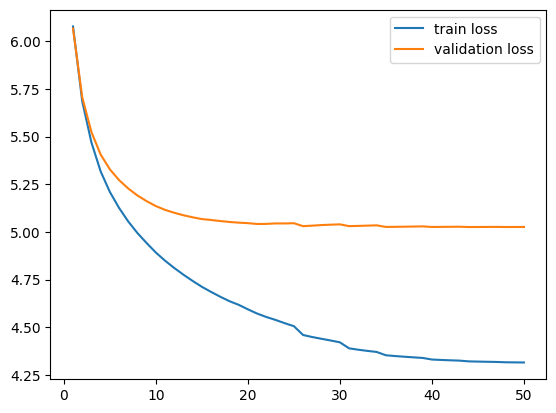

In [26]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(model.train_loss)+1), model.train_loss, label='train loss')
ax.plot(np.arange(1, len(model.val_loss)+1), model.val_loss, label='validation loss')
ax.legend()

With the 2 layers in the LSTM network and using a learning rate shceduler we reach an improved perplexity rating of 146.25 on the test set:

In [27]:
model = torch.load(fname_best)
test_loss = evaluate(val_data)
print('Best model obtained in epoch                  ', model.epoch)
print('The perpelexity in the validation set is {:8.2f}'.format(math.exp(test_loss)))
test_loss = evaluate(test_data)
print('The perpelexity in the test set is       {:8.2f}'.format(math.exp(test_loss)))

Best model obtained in epoch                   44
The perpelexity in the validation set is   152.29
The perpelexity in the test set is         146.25
